# Experimento

El propósito de este experimento es encontrar una situación en la que de tres experimentos que tienen un rendimiento similar, al obtener diferencias con el "ganador" o "más alto desempeño" las diferencias con el más cercano competidor son significativas pero con el tercer competidor no lo son.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from CompStats import performance, plot_performance
from CompStats import difference, plot_difference
from sklearn.metrics import f1_score

In [2]:
# La siguiente función da como salida una copia del vector de entrada, alterando aleatoriamente una proporcion "prop" de los valores de entrada.
# la función está pensada en valor 0 y 1.
def alterar_vector(vector, prop):
    # Número total de elementos a modificar
    n_alterar = int(len(vector) * prop)
    
    # Índices aleatorios de los elementos a modificar
    indices_a_modificar = np.random.choice(len(vector), size=n_alterar, replace=False)
    
    # Alterar los valores en los índices seleccionados
    vector_modificado = vector.copy()
    vector_modificado[indices_a_modificar] = 1 - vector_modificado[indices_a_modificar]
    
    return vector_modificado


## Parámetros del experimento
Los parámetros utilizados son:

$n$ es el número de valores del dataset.

'prob_1_col1' es $P(X=1)$, por lo tanto $P(X=0)=1-P(X=1)$

'prob_1_col2_given_col1_1' es $P(y=1|X = 1)$, por lo que $P(y=0|X = 1) = 1-P(y=1|X = 1)$

'prob_1_col2_given_col1_0' es $P(y=1|X = 0)$, por lo que $P(y=0|X = 0) = 1-P(y=1|X = 0)$


In [3]:

# Parámetros
n = 500
prob_1_col1 = 0.6
prob_1_col2_given_col1_1 = 0.8
prob_1_col2_given_col1_0 = 0.3
p12 = 0.08
p3 = 0.36


A partir de los parámetros anteriores se obtiene un dataframe 'dforiginal' cuya primer columna denominada 'X' es un vector de $n$ valores de aproximadamente $n_1 = n * P(X = 1)$ valores $1$ y $n_0 = n * P(X = 0)$ valores $0$ . 

La segunda columna se denomina 'y' será el *ground truth* y tendrá aproximadamente $[n * (P(y=1|X = 1) + P(y=1|X = 0))]$ valores $1$ y  $[n * (P(y=0|X = 1) + P(y=0|X = 0))]$ valores $0$. 

La tercer columna denominada 'pred1' se obtiene al azar siguiendo la misma forma de construcción que la segunda columna. No significa que son columnas iguales.

La cuarta columna llamada 'pred2' es una copia de 'pred1' alterando al azar aproximadamente el $8\%$ de los valores.

Por último, la quinta columna denominada 'pred3' es una copia del *ground truth*  'y' alterando al azar aproximadamente el $36\%$.


In [4]:
np.random.seed(0)
# Generar la primera columna con 60% de 1's y 40% de 0's
col1 = np.random.choice([1, 0], size=n, p=[prob_1_col1, 1-prob_1_col1])

# Generar la segunda columna basada en la primera
col2 = np.array([
    np.random.choice([1, 0], p=[prob_1_col2_given_col1_1, 1-prob_1_col2_given_col1_1]) if val == 1 
    else np.random.choice([1, 0], p=[prob_1_col2_given_col1_0, 1-prob_1_col2_given_col1_0]) 
    for val in col1
])
col3 = np.array([
    np.random.choice([1, 0], p=[prob_1_col2_given_col1_1, 1-prob_1_col2_given_col1_1]) if val == 1 
    else np.random.choice([1, 0], p=[prob_1_col2_given_col1_0, 1-prob_1_col2_given_col1_0]) 
    for val in col1
])

col4 = alterar_vector(col3,p12)
col5 = alterar_vector(col2,p3)

# Crear el DataFrame
dforiginal = pd.DataFrame({'X': col1, 'y': col2, 'pred1': col3,'pred2': col4,'pred3': col5})

# Mostrar el DataFrame
print(dforiginal.head())




   X  y  pred1  pred2  pred3
0  1  1      1      1      1
1  0  0      1      1      1
2  0  0      0      1      0
3  1  1      1      1      0
4  1  1      1      1      1


Ahora creamos el dataframe 'df' con el *ground truth* y las tres predicciones, es decir se omite la columna 'X' que se utilizó como mecanismo de creación de 'y', 'pred1' y 'pred2' (este último de forma indirecta).

In [5]:
df = dforiginal.iloc[:,1:]

Como se puede ver a continuación con el reporte de clasificación de las tres predicciones, son similares los resultados a primera vista.

In [6]:
print(classification_report(df.y,df.pred1))
print(classification_report(df.y,df.pred2))
print(classification_report(df.y,df.pred3))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57       204
           1       0.71      0.70      0.70       296

    accuracy                           0.65       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.65      0.65      0.65       500

              precision    recall  f1-score   support

           0       0.53      0.54      0.53       204
           1       0.68      0.67      0.67       296

    accuracy                           0.61       500
   macro avg       0.60      0.60      0.60       500
weighted avg       0.62      0.61      0.61       500

              precision    recall  f1-score   support

           0       0.55      0.67      0.60       204
           1       0.73      0.62      0.67       296

    accuracy                           0.64       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.66      0.64      0.64       500



## Bootstrap para inferencia

A continuación se obtendrán las muestras *bootstrap* para hacer inferencia sobre la métrica de desempeño de las tres predicciones.

Primero definimos o seleccionamos la métrica, en este caso *f1-score*. Posteriormente se calcula la métrica *f1-score* para '1000' muestras *bootstrap* del dataset.

In [7]:
score = lambda y, hy: f1_score(y, hy)
perf = performance(df, score=score,num_samples=1000)

A partir de las muestras *bootstrap* de rendimiento obtenemos el intervalo de confianza del $95\%$ para cada predicción. Como se puede apreciar, los intervalos de confianza se traslapan, aunque 'pred1' se aprecia que tiene mejor desempeño. De hecho, de estos datos el orden de desempeño sería 'pred1', 'pred2', 'pred3'.

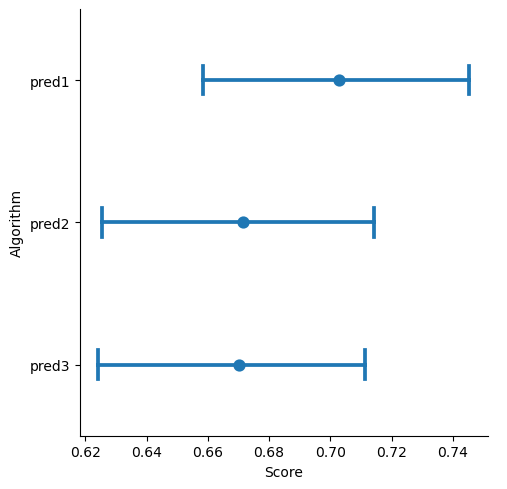

In [8]:
face_grid = plot_performance(perf)

Ahora, para poder responder la pregunta si una predicción es mejor que otra obtenemos las diferencias de rendimiento comparando contra el *mejor*, es decir contra 'pred1'

In [9]:
diff = difference(perf)
diff.info

{'best': 'pred1'}

Al graficar los intervalos de confianza de las diferencias contra el mejor, podemos apreciar que al evaluar el intervalo de confianza de 'pred1'-'pred2', el intervalo de confianza es angosto dada la gran asociación entre las dos predicciones, pero es suficientemente distinta de cero como para que sea significativa.  

En cambio, en el caso de 'pred1'-'pred3' es un intervalo más amplio, dado que no tienen una asociación debido al mecanismo de simulación, y la diferencia no es significativa.


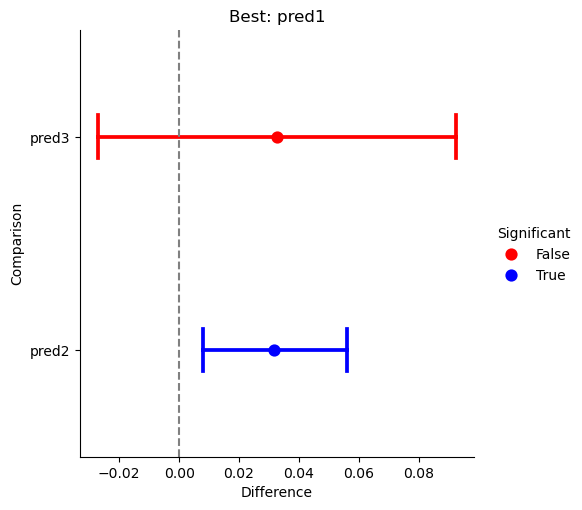

In [10]:
face_grid_diff = plot_difference(diff)

In [11]:
print(pd.crosstab(dforiginal.X,dforiginal.y))
print(pd.crosstab(dforiginal.X,dforiginal.pred1))
print(pd.crosstab(dforiginal.X,dforiginal.pred2))
print(pd.crosstab(dforiginal.X,dforiginal.pred3))

y    0    1
X          
0  142   54
1   62  242
pred1    0    1
X              
0      142   54
1       65  239
pred2    0    1
X              
0      134   62
1       75  229
pred3    0    1
X              
0      108   88
1      140  164


In [12]:
# normalización por renglón
print(pd.crosstab(dforiginal.X,dforiginal.y,normalize='index'))
print(pd.crosstab(dforiginal.X,dforiginal.pred1,normalize='index'))
print(pd.crosstab(dforiginal.X,dforiginal.pred2,normalize='index'))
print(pd.crosstab(dforiginal.X,dforiginal.pred3,normalize='index'))

y         0         1
X                    
0  0.724490  0.275510
1  0.203947  0.796053
pred1         0         1
X                        
0      0.724490  0.275510
1      0.213816  0.786184
pred2         0         1
X                        
0      0.683673  0.316327
1      0.246711  0.753289
pred3         0         1
X                        
0      0.551020  0.448980
1      0.460526  0.539474


In [13]:
print(pd.crosstab(dforiginal.y,dforiginal.pred1))
print(pd.crosstab(dforiginal.y,dforiginal.pred2))
print(pd.crosstab(dforiginal.y,dforiginal.pred3))

pred1    0    1
y              
0      118   86
1       89  207
pred2    0    1
y              
0      110   94
1       99  197
pred3    0    1
y              
0      136   68
1      112  184


Recuerde que:

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

In [14]:
print(f1_score(df.y,df.pred1))
print(f1_score(df.y,df.pred2))
print(f1_score(df.y,df.pred3))

0.7028862478777589
0.6712095400340715
0.6715328467153284


In [15]:
print(pd.crosstab(dforiginal.pred1,dforiginal.pred2))
print(pd.crosstab(dforiginal.pred1,dforiginal.pred3))

pred2    0    1
pred1          
0      188   19
1       21  272
pred3    0    1
pred1          
0       98  109
1      150  143


In [16]:
np.random.seed(0)
nsim = 1000
results = []
for i in range(nsim):
    # Generar la primera columna con 60% de 1's y 40% de 0's
    col1 = np.random.choice([1, 0], size=n, p=[prob_1_col1, 1-prob_1_col1])
    # Generar la segunda columna basada en la primera
    col2 = np.array([
        np.random.choice([1, 0], p=[prob_1_col2_given_col1_1, 1-prob_1_col2_given_col1_1]) if val == 1 
        else np.random.choice([1, 0], p=[prob_1_col2_given_col1_0, 1-prob_1_col2_given_col1_0]) 
        for val in col1
    ])
    col3 = np.array([
    np.random.choice([1, 0], p=[prob_1_col2_given_col1_1, 1-prob_1_col2_given_col1_1]) if val == 1 
    else np.random.choice([1, 0], p=[prob_1_col2_given_col1_0, 1-prob_1_col2_given_col1_0]) 
    for val in col1
    ])
    col4 = alterar_vector(col3,p12)
    col5 = alterar_vector(col2,p3)

    results.append((f1_score(col2,col3),f1_score(col2,col4),f1_score(col2,col5)))

In [17]:
results_df = pd.DataFrame(results,columns = ['f1_m1','f1_m2','f1_m3'])
results_df.describe()

,f1_m1,f1_m2,f1_m3
count,1000.000000,1000.000000,1000.000000
mean,0.698179,0.675110,0.679684
std,0.021429,0.022064,0.009889
min,0.624573,0.605536,0.647059
25%,0.684430,0.660698,0.672727
50%,0.699064,0.674956,0.679715
75%,0.712159,0.690804,0.686411
max,0.772152,0.746032,0.705882


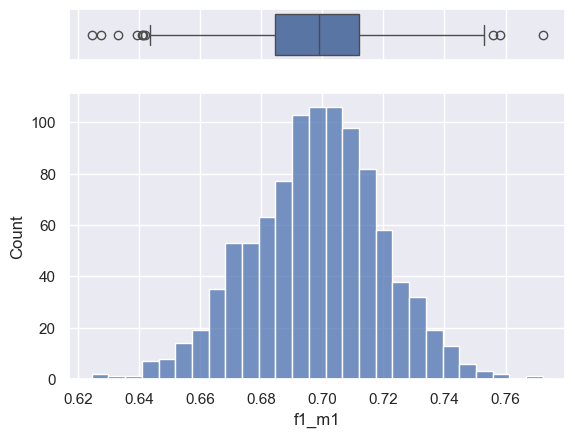

In [18]:
sns.set_theme(style="darkgrid")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(results_df['f1_m1'], orient="h", ax=ax_box)
sns.histplot(data=results_df, x='f1_m1', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

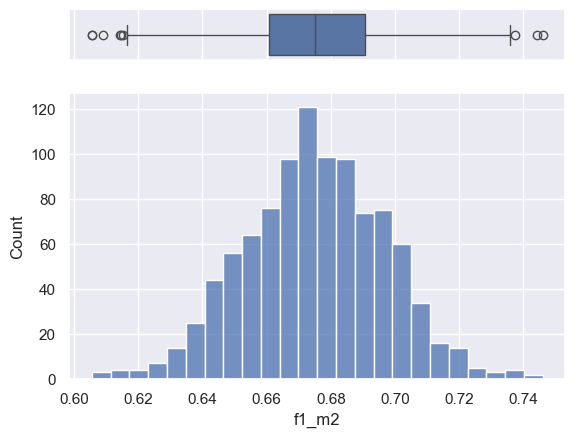

In [19]:
sns.set_theme(style="darkgrid")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(results_df['f1_m2'], orient="h", ax=ax_box)
sns.histplot(data=results_df, x='f1_m2', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

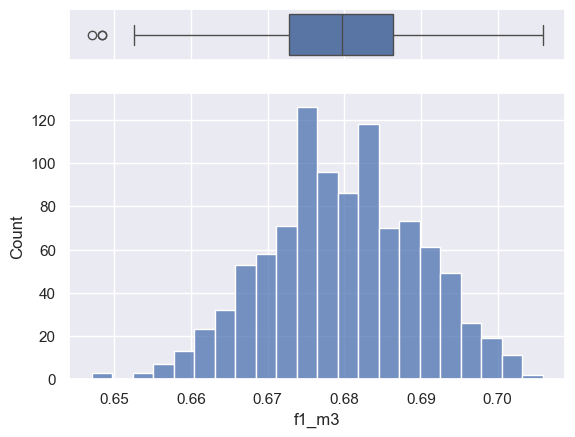

In [20]:
sns.set_theme(style="darkgrid")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(results_df['f1_m3'], orient="h", ax=ax_box)
sns.histplot(data=results_df, x='f1_m3', ax=ax_hist)
 
# Remove x axis name for the boxplot

ax_box.set(xlabel='')
plt.show()